# Precision/Recall Analysis by Group

This section evaluates precision and recall by group using Fairlearn. If the difference in recall (Δ Recall) exceeds 0.10, mitigation strategies such as re-weighting or threshold tuning will be demonstrated.

In [2]:
# Import necessary libraries
from fairlearn.metrics import MetricFrame
from sklearn.metrics import recall_score, precision_score
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.metrics import make_scorer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from fairlearn.metrics import MetricFrame

%run dataInfo.ipynb
cleanTrain = train_df
cleanTest = test_df
sensitive_feature = cleanTrain['gender']

In [3]:

def evaluate_group_distribution(model, X, sensitive_feature, group_name='Group', title='Probability Distribution by Group'):
    """
    Evaluate and visualize the distribution of predicted probabilities across sensitive groups.
    Does not require true labels.
    
    Parameters:
    - model: trained classifier (must support predict_proba)
    - X: input features (aligned with training columns, already preprocessed)
    - sensitive_feature: Series of sensitive attribute values (e.g., gender)
    - group_name: string label for the sensitive feature (e.g., 'Gender')
    - title: plot title
    """
    # Get predicted probabilities for class 1
    y_pred_proba = model.predict_proba(X)[:, 1]

    # Create dataframe for analysis
    df = pd.DataFrame({
        'probability': y_pred_proba,
        group_name: sensitive_feature.reset_index(drop=True)
    })

    # Plot distributions by group
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='probability', hue=group_name, fill=True, common_norm=False, alpha=0.4)
    plt.title(title)
    plt.xlabel('Predicted Probability of Class 1')
    plt.ylabel('Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    summary = df.groupby(group_name)['probability'].describe()
    print(f"\nProbability Summary by {group_name}:\n")
    print(summary)

In [4]:

def calculate_difference(model, X_test, y_test, sensitive_feature, metric_name='Recall'):
    from fairlearn.metrics import MetricFrame
    print(y_test.value_counts())

    # Get predictions
    y_pred = model.predict(X_test)
    print("Predicted class counts:", pd.Series(y_pred).value_counts())
    
    # Construct metric frame
    metric_frame = MetricFrame(
        metrics={
            "Precision": precision_score,
            "Recall": recall_score
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=sensitive_feature
    )

    # Show group-wise metrics
    print("Group-wise Precision and Recall:")
    print(metric_frame.by_group)

    # Check disparity
    delta = metric_frame.difference(method="between_groups")[metric_name]
    print(f"\nΔ {metric_name}: {delta:.3f}")

    if delta > 0.10:
        print("⚠️ Δ Recall exceeds 0.10. Applying mitigation using GridSearch and Demographic Parity...")

        mitigator = GridSearch(
            estimator=model,
            constraints=DemographicParity(),
            grid_size=20
        )
        mitigator.fit(X_test, y_test, sensitive_features=sensitive_feature)

        mitigated_model = mitigator.best_estimator_
        mitigated_preds = mitigated_model.predict(X_test)

        mitigated_metric_frame = MetricFrame(
            metrics={
                "Precision": precision_score,
                "Recall": recall_score
            },
            y_true=y_test,
            y_pred=mitigated_preds,
            sensitive_features=sensitive_feature
        )

        print("\n✅ Mitigated Group-wise Precision and Recall:")
        print(mitigated_metric_frame.by_group)

    else:
        print("✅ Δ Recall is within acceptable limits. No mitigation needed.")
    
    # Step 1: Get predicted probabilities on the audit set
    y_proba = model.predict_proba(X_test)[:, 1]  # Replace with your model if needed

    # Step 2: Find best threshold using F1
    def tune_threshold(y_true, y_proba, metric=f1_score):
        best_thresh = 0.5
        best_score = 0
        for thresh in np.arange(0.1, 0.9, 0.01):
            preds = (y_proba >= thresh).astype(int)
            score = metric(y_true, preds)
            if score > best_score:
                best_score = score
                best_thresh = thresh
        print(f"Best threshold: {best_thresh:.2f} with {metric.__name__}: {best_score:.4f}")
        return best_thresh

    best_thresh = tune_threshold(y_test, y_proba)
    y_pred = (y_proba >= best_thresh).astype(int)

    # Step 3: Fairness metrics by sensitive group
    metric_frame = MetricFrame(
        metrics={"Precision": precision_score, "Recall": recall_score},
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=sensitive_feature
    )

    print("Group-wise Precision and Recall after threshold tuning:")
    print(metric_frame.by_group)
    print(f"Δ Recall: {metric_frame.difference(method='between_groups')['Recall']:.3f}")
    print(f"Δ Precision: {metric_frame.difference(method='between_groups')['Precision']:.3f}")

    # Step 4: Plot metric values across thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1s, precisions, recalls = [], [], []

    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        f1s.append(f1_score(y_test, preds))
        precisions.append(precision_score(y_test, preds))
        recalls.append(recall_score(y_test, preds))

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1s, label='F1 Score')
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Metric Scores vs Threshold")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

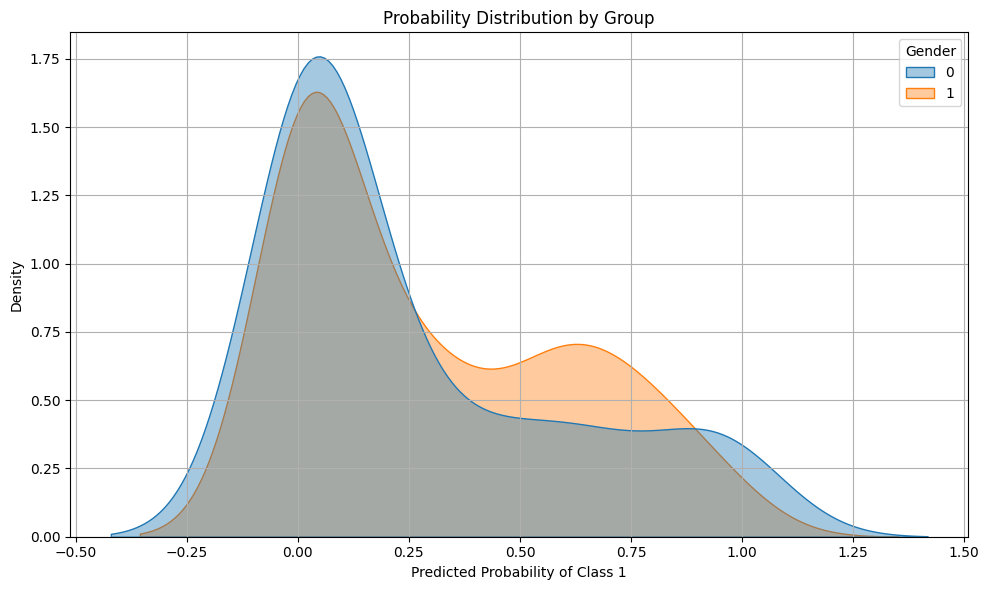


Probability Summary by Gender:

        count      mean       std  min       25%       50%       75%       max
Gender                                                                        
0        75.0  0.265244  0.332965  0.0  0.018333  0.066667  0.476667  0.996667
1       125.0  0.300933  0.311500  0.0  0.013333  0.186667  0.573333  0.996667
Class/ASD
0    128
1     32
Name: count, dtype: int64
Predicted class counts: 1    160
Name: count, dtype: int64
Group-wise Precision and Recall:
        Precision  Recall
gender                   
0        0.175000     1.0
1        0.208333     1.0

Δ Recall: 0.000
✅ Δ Recall is within acceptable limits. No mitigation needed.
Best threshold: 0.61 with f1_score: 0.3368
Group-wise Precision and Recall after threshold tuning:
        Precision  Recall
gender                   
0        0.175000     1.0
1        0.211864     1.0
Δ Recall: 0.000
Δ Precision: 0.037


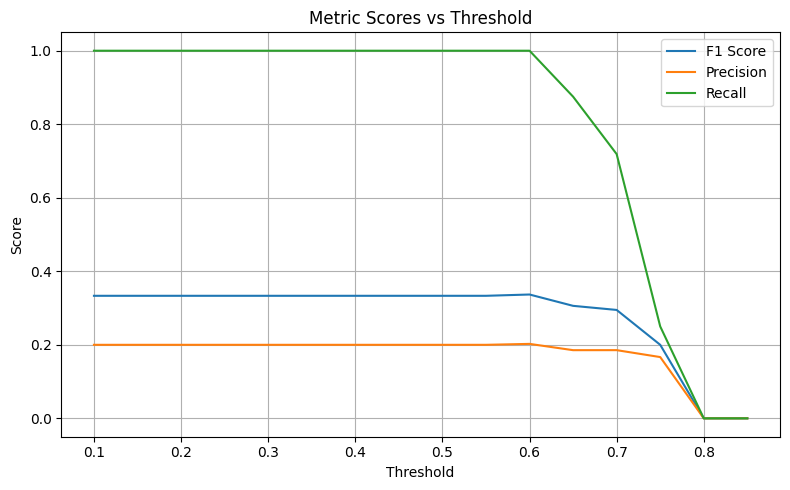

In [5]:
# Run the Random Forest model notebook to load the model and data
%run SupervisedModels/SupervisedRandomForest.ipynb

# Evaluate metrics using the simulated target variable
evaluate_group_distribution( 
    model=rf_model, 
    X=X_test, 
    sensitive_feature=cleanTest.loc[X_test.index, 'gender'], 
    group_name='Gender'
)
calculate_difference(
    model=rf_model,
    X_test=X_holdout,
    y_test=y_holdout,
    sensitive_feature=X_holdout.loc[X_holdout.index, 'gender'],
    metric_name='Recall'
)


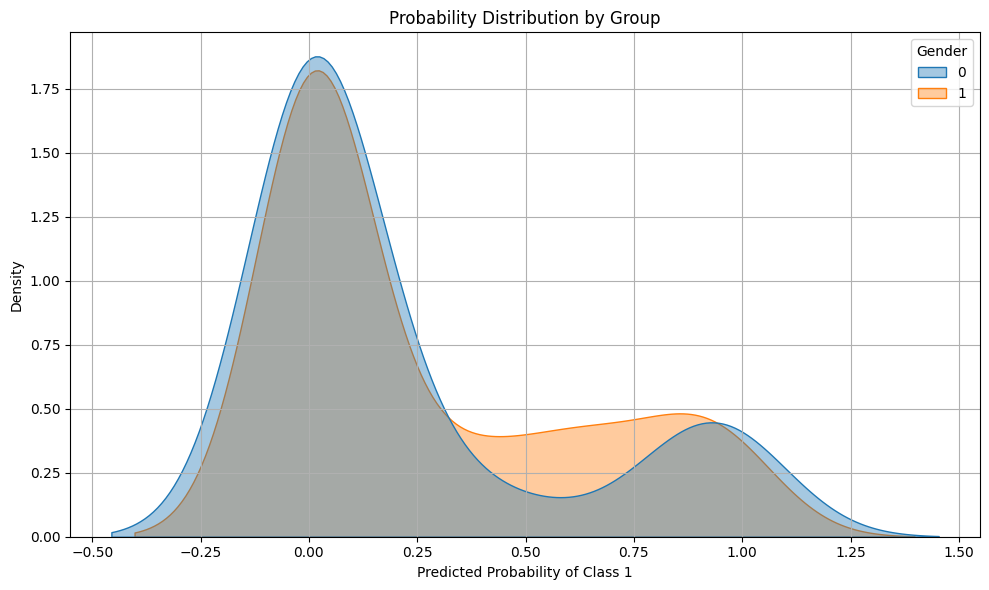


Probability Summary by Gender:

        count      mean       std       min       25%       50%       75%  \
Gender                                                                      
0        75.0  0.217954  0.360395  0.000049  0.000780  0.005085  0.238455   
1       125.0  0.264355  0.352316  0.000016  0.000271  0.024408  0.568127   

             max  
Gender            
0       0.997275  
1       0.994917  
Class/ASD
0    128
1     32
Name: count, dtype: int64
Predicted class counts: 1    160
Name: count, dtype: int64
Group-wise Precision and Recall:
        Precision  Recall
gender                   
0        0.175000     1.0
1        0.208333     1.0

Δ Recall: 0.000
✅ Δ Recall is within acceptable limits. No mitigation needed.
Best threshold: 0.88 with f1_score: 0.4854
Group-wise Precision and Recall after threshold tuning:
        Precision    Recall
gender                     
0        0.187500  0.857143
1        0.487179  0.760000
Δ Recall: 0.097
Δ Precision: 0.300


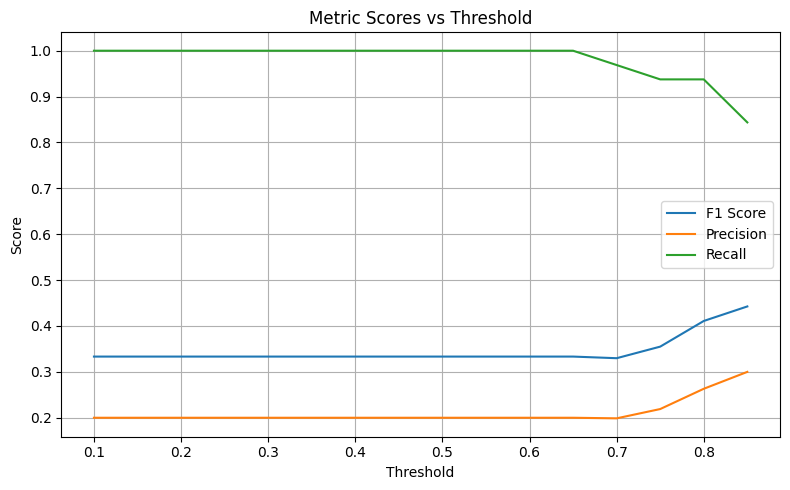

In [6]:
# Run the Cat Boost model notebook to load the model and data
%run SupervisedModels/SupervisedCatBoost.ipynb

# Evaluate metrics using the simulated target variable
evaluate_group_distribution( 
    model=cb_model, 
    X=X_test, 
    sensitive_feature=cleanTest.loc[X_test.index, 'gender'], 
    group_name='Gender'
)
calculate_difference(
    model=cb_model,
    X_test=X_holdout,
    y_test=y_holdout,
    sensitive_feature=X_holdout.loc[X_holdout.index, 'gender'],
    metric_name='Recall'
)


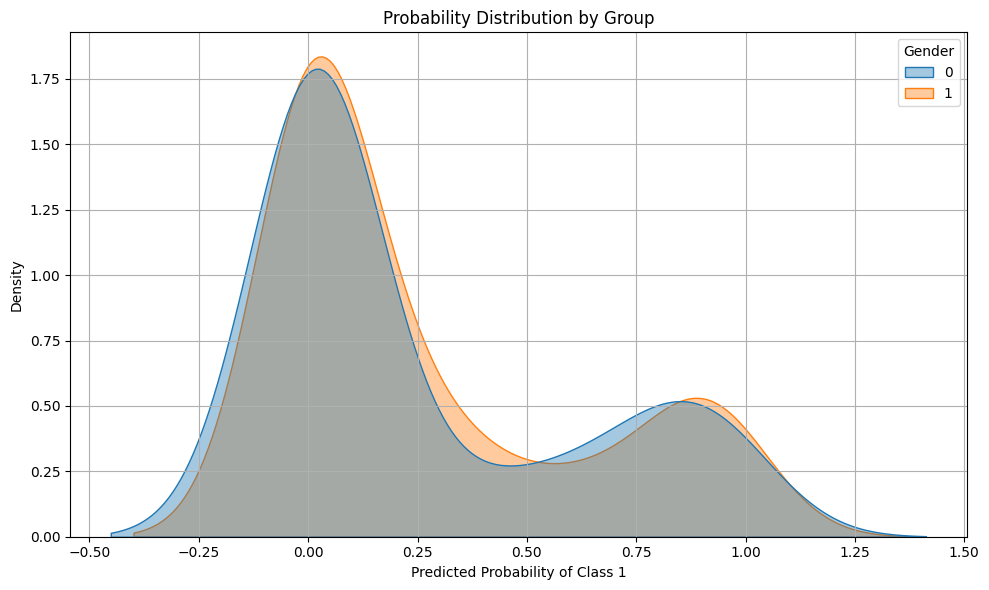


Probability Summary by Gender:

        count      mean       std       min       25%       50%       75%  \
Gender                                                                      
0        75.0  0.247641  0.356795  0.000116  0.004115  0.024193  0.512372   
1       125.0  0.260016  0.349556  0.000003  0.000824  0.033785  0.489317   

             max  
Gender            
0       0.961009  
1       0.987027  
Class/ASD
0    128
1     32
Name: count, dtype: int64
Predicted class counts: 1    133
0     27
Name: count, dtype: int64
Group-wise Precision and Recall:
        Precision  Recall
gender                   
0        0.184211     1.0
1        0.263158     1.0

Δ Recall: 0.000
✅ Δ Recall is within acceptable limits. No mitigation needed.
Best threshold: 0.89 with f1_score: 0.4414
Group-wise Precision and Recall after threshold tuning:
        Precision  Recall
gender                   
0        0.205882     1.0
1        0.316456     1.0
Δ Recall: 0.000
Δ Precision: 0.111


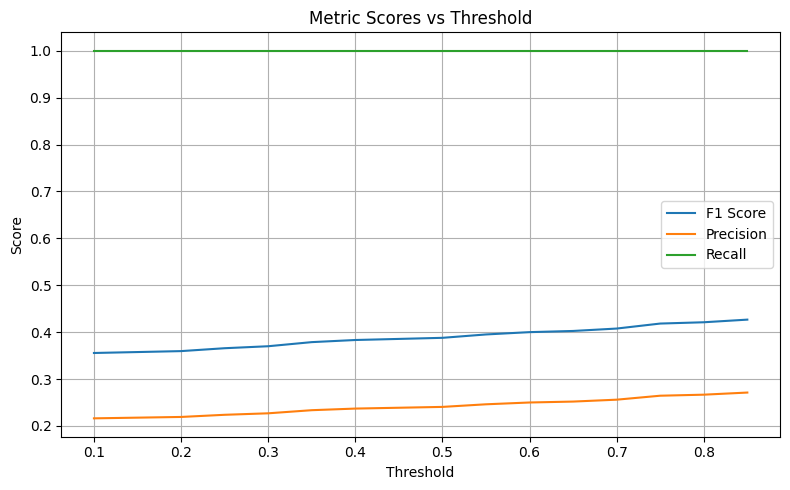

In [7]:
# Run the Logistic Regression model notebook to load the model and data
%run SupervisedModels/SupervisedlogisticRegression.ipynb

# Evaluate metrics using the simulated target variable
evaluate_group_distribution( 
    model=lr_model, 
    X=X_test, 
    sensitive_feature=cleanTest.loc[X_test.index, 'gender'], 
    group_name='Gender'
)
calculate_difference(
    model=lr_model,
    X_test=X_holdout,
    y_test=y_holdout,
    sensitive_feature=X_holdout.loc[X_holdout.index, 'gender'],
    metric_name='Recall'
)

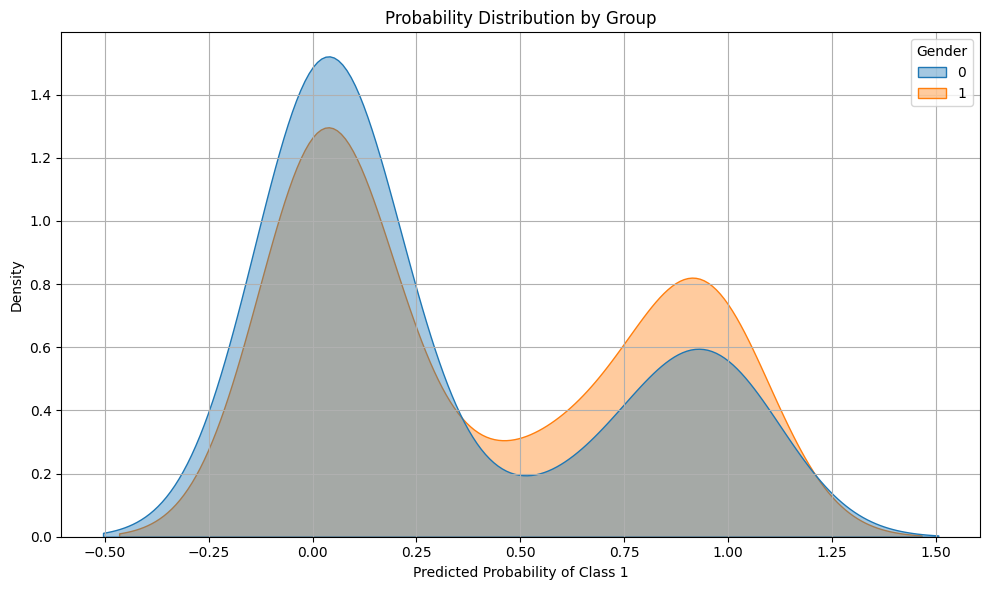


Probability Summary by Gender:

        count      mean       std       min       25%       50%       75%  \
Gender                                                                      
0        75.0  0.309930  0.404501  0.007032  0.010213  0.043045  0.798192   
1       125.0  0.401689  0.413391  0.006241  0.010942  0.181682  0.890759   

             max  
Gender            
0       0.994823  
1       0.994145  
Class/ASD
0    128
1     32
Name: count, dtype: int64
Predicted class counts: 1    160
Name: count, dtype: int64
Group-wise Precision and Recall:
        Precision  Recall
gender                   
0        0.175000     1.0
1        0.208333     1.0

Δ Recall: 0.000
✅ Δ Recall is within acceptable limits. No mitigation needed.
Best threshold: 0.10 with f1_score: 0.3333
Group-wise Precision and Recall after threshold tuning:
        Precision  Recall
gender                   
0        0.175000     1.0
1        0.208333     1.0
Δ Recall: 0.000
Δ Precision: 0.033


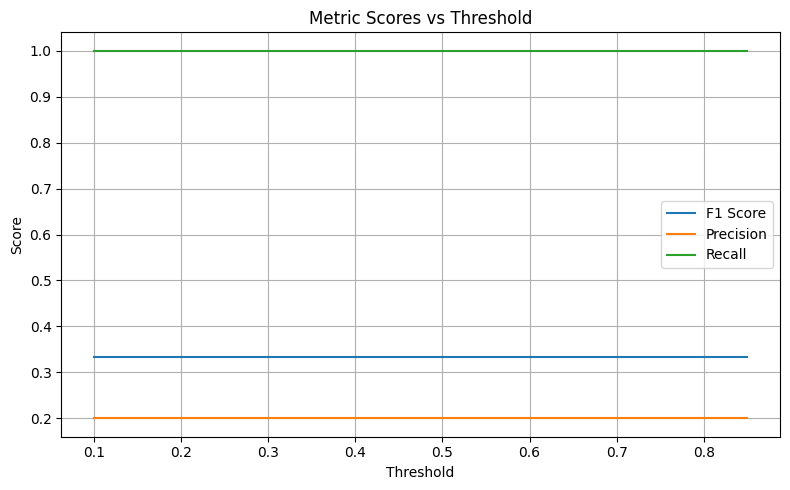

In [8]:
# Run the XG Boost model notebook to load the model and data
%run SupervisedModels/SupervisedXGBoost.ipynb

# Evaluate metrics using the simulated target variable
evaluate_group_distribution( 
    model=xgb_model, 
    X=X_test, 
    sensitive_feature=cleanTest.loc[X_test.index, 'gender'], 
    group_name='Gender'
)
calculate_difference(
    model=xgb_model,
    X_test=X_holdout,
    y_test=y_holdout,
    sensitive_feature=X_holdout.loc[X_holdout.index, 'gender'],
    metric_name='Recall'
)
